[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
solubilidades en kg/m³: 2110.0 concentraciones iniciales: [20.  5.  0.]


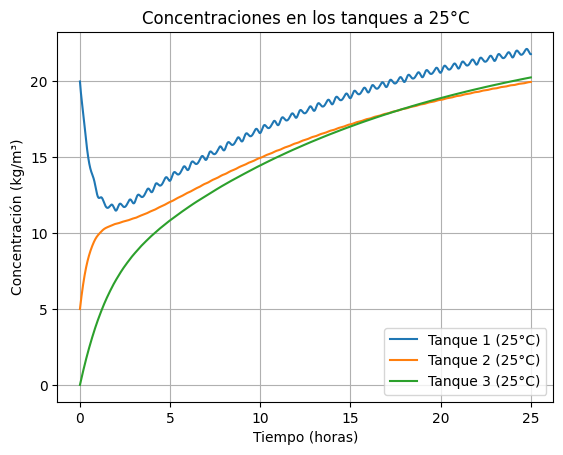

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  
from scipy.integrate import solve_ivp


# Volúmenes de los tanques (m^3)
V1 = 1.0
V2 = 1.2
V3 = 1.5

# Concentraciones iniciales (kg/m^3)
C1_0 = 20.0
C2_0 = 5.0
C3_0 = 0.0

# Conversión de caudales: L/min -> m^3/s
def Lmin_to_m3s(Q_Lmin):
    return (Q_Lmin / 1000.0) / 60.0

# Caudales externos (m^3/s)
Q0 = Lmin_to_m3s(0.3)
Q1 = Lmin_to_m3s(1.5)
Q2 = Lmin_to_m3s(1.8)
Q3 = Lmin_to_m3s(0.6)

# Caudales internos (calculados previamente por balance) en L/min -> m^3/s
QA = Lmin_to_m3s(18.72)
QB = Lmin_to_m3s(15.84)
QC = Lmin_to_m3s(12.0)

# Concentraciones de alimentación (kg/m^3)
c_Q0 = 0.0                    # Línea 0
c_Q2 = 6.25e3 / 1000.0        # Línea 2: 6.25×10^3 g/m^3 -> 6.25 kg/m^3

# Concentración de Línea 1 es variable:
# c_Q1(t) = c1*(2.0 + sin(0.003491 t) + 0.3 sin(0.005236 t))
# con c1 = 2.5e4 g/m^3 = 25 kg/m^3

c1 = 2.5e4  / 1000.0   # 25 kg/m^3

def c_Q1(t):
    return c1 * (2.0 + np.sin(0.003491*t) + 0.3*np.sin(0.005236*t))

# Definición de tiempo
t = 0.0         # Tiempo inicial (s)
t_final = 2.5*3600*10    # Tiempo final (s)
dt = 1   # Paso de tiempo (s)

#creación del vector de tiempo
time_vector = np.arange(t, t_final + dt, dt)

temperaturas = [0, 25, 75, 100]  # °C
solubilidades = [179, 211, 340, 487]  # g/ml
def func_solubilidad(temp):
    """Interpolación cuadrática de solubilidad en función de temperatura"""
    return interp1d(temperaturas, solubilidades, kind='quadratic', fill_value='extrapolate')(temp)*10*1000

#creación de la matriz para almacenar las concentraciones
concentrations = np.zeros((len(time_vector), 3))  # 3 tanques
print(concentrations)
#rellenar la primera fila con las concentraciones iniciales

concentrations[0, :] = [C1_0, C2_0, C3_0]
def solucion_con_solubilidad(temperatura, matriz_concentraciones, vector_tiempo):
    """Simulación de las concentraciones en los tanques considerando la solubilidad variable"""
    solubility = func_solubilidad(temperatura) / 1000.0  # Convertir g/m³ a kg/m³
    print("solubilidades en kg/m³:", solubility, "concentraciones iniciales:", matriz_concentraciones[0, :])
    for i in range(len(vector_tiempo) - 1):
        t = vector_tiempo[i]
        x, y, z = matriz_concentraciones[i, :]
        dxdt = (Q1*c_Q1(t) +(1/2)*QB*y + (3/4)*QC*z - QA*x) / V1
        dydt = ((3/4)*QA*x + Q2*c_Q2 - QB*y) / V2
        dzdt = ((1/4)*QA*x + (1/2)*QB*y - (QC + Q3)*z) / V3
        # Ajustar concentraciones si superan la solubilidad
        if x > solubility:
            x = solubility
        
        if y > solubility:
            y = solubility
        if z > solubility:
            z = solubility
        # Actualizar concentraciones para el siguiente paso de tiempo

        matriz_concentraciones[i+1, :] = [x + dxdt*dt, y + dydt*dt, z + dzdt*dt]

    return matriz_concentraciones

# simulación para 25°C
concentrations_25C = solucion_con_solubilidad(25, concentrations.copy(), time_vector)
plt.plot(time_vector/3600, concentrations_25C[:, 0], label='Tanque 1 (25°C)')
plt.plot(time_vector/3600, concentrations_25C[:, 1], label='Tanque 2 (25°C)')
plt.plot(time_vector/3600, concentrations_25C[:, 2], label='Tanque 3 (25°C)')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Concentración (kg/m³)')
plt.title('Concentraciones en los tanques a 25°C')
plt.legend()
plt.grid()
plt.show()